{1: 10000, 3: 10000, 5: 10000, 10: 10000, 50: 84.01124306640622, 'adaptive': 28.014985559765634}
defaultdict(<class 'dict'>, {0.99: {1: 10000, 3: 10000, 5: 10000, 10: 20.06960675976562, 50: 75.61011875976561, 'adaptive': 17.38390494648438}, 0.95: {1: 10000, 3: 10000, 5: 9.48064199316406, 10: 14.494715993164059, 50: 37.80505937988281, 'adaptive': 11.72478248652344}, 0.9: {1: 10000, 3: 10000, 5: 6.563521379882811, 10: 8.9198252265625, 50: 33.6044972265625, 'adaptive': 7.222754026562501}, 0.8: {1: 10000, 3: 4.025006673242188, 5: 5.104961073242187, 10: 6.689868919921875, 50: 25.203372919921875, 'adaptive': 4.992797719921875}, 0.6: {1: 10000, 3: 2.30000381328125, 5: 2.1878404599609373, 10: 3.344934459960937, 50: 8.401124306640625, 'adaptive': 1.6478632599609373}, 0.4: {1: 0.4207217533203125, 3: 1.150001906640625, 5: 1.458560306640625, 10: 1.1149781533203125, 50: 4.200562153320313, 'adaptive': 0.4207217533203125}})
defaultdict(<class 'dict'>, {0.99: 'adaptive', 0.95: 5, 0.9: 5, 0.8: 3, 0.6: 

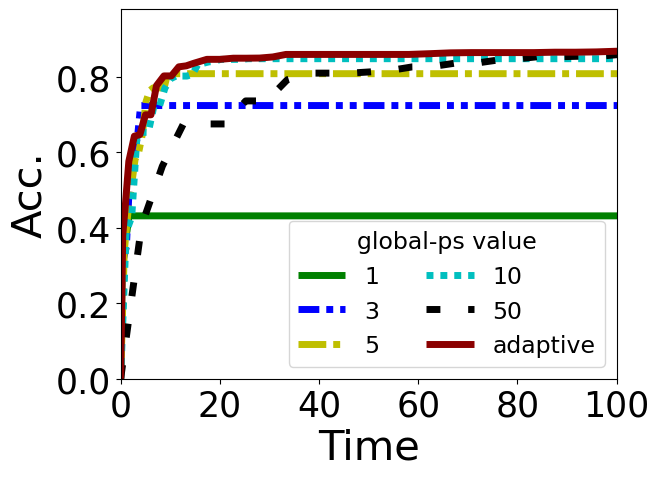

In [12]:
# figure 8 

import os 
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

dict1 = defaultdict(dict)
relative_ratio = [0.99,0.95,0.9,0.8,0.6,0.4]

dataset = "agnews"
model = "distilbert"

train_time_dict = {"ours":0.3085584,'fedadapter':1.3878,"adapter":4.1634,"bitfit":4.1634,"full":6.939}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.85
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['g','b','y','c','k'] * 100
lw = 5

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

v_num_list = [1,3,5,10,50]
method = "ours"
for i,v in enumerate(v_num_list):
    file = f'../figure8/fedFwd_distilbert_agnews_lr0.01_client_num_10_numerical_muti_v{v}.log'
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        adhoc = f'{v},{v},{v}'
        max_acc = 0
        for line in f:
            if "'acc':" in line:
                cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
                if cur_acc>max_acc:
                    max_acc = cur_acc
                else:
                    cur_acc = max_acc
                acc.append(cur_acc)
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        for ratio in relative_ratio:
            time_to_acc_dict[v] = get_time_to_target_acc(target_acc,acc,time_list)
            dict1[ratio][v] = get_time_to_target_acc(target_acc*ratio,acc,time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=f'{v}',linewidth=lw)

file = "/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_10_numerical_adhoc.log"
v = 'adaptive'
with open(file) as f:
    for line in f:
        if "Trainable" in line:
            param_num = int(line[line.rfind(":")+2:-2])
            break
        if "adhoc" in line:
            adhoc = line[line.rfind("[")+1:line.rfind("]")]
    comm_time = param_num * 4 / comm_bandwidth
    acc = [0]
    # adhoc = f'{v},{v},{v}'
    max_acc = 0
    for line in f:
        if "'acc':" in line:
            cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
            if cur_acc>max_acc:
                max_acc = cur_acc
            else:
                cur_acc = max_acc
            acc.append(cur_acc)
    time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
    for ratio in relative_ratio:
        time_to_acc_dict[v] = get_time_to_target_acc(target_acc,acc,time_list)
        dict1[ratio][v] = get_time_to_target_acc(target_acc*ratio,acc,time_list)
    plt.plot(time_list, acc, linestyle=(0, ()), color='darkred',label=f'{v}',linewidth=lw)

print(time_to_acc_dict)
print(dict1)
for k,v in dict1.items():
    cur_min = 10000
    for key,value in v.items():
        if value < cur_min:
            new_v = key
            cur_min = value
    dict1[k] = new_v
print(dict1)

plt.xlabel("Time",fontsize=30)
plt.ylabel("Acc.",fontsize=30)
plt.xticks(size = 25)
plt.xlim(0,100)
plt.yticks(size = 25)
plt.ylim(0,0.98)
plt.legend(fontsize=17,ncol=2,title='global-ps value',title_fontsize=17)
# plt.title(f"{model} {dataset}",fontsize=30)
plt.savefig("/data/wyz/ForwardFL-Latex/figs/eval-ablation-adaptive.pdf", bbox_inches="tight")
# plt.savefig("/data/wyz/ForwardFL-Latex/figs/design-planning-configuration_wyz.pdf", bbox_inches="tight")
plt.show()